In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
import pickle
import os
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.optimizers import SGD

# Material constant ranges from Table 1
material_constant_ranges = {
    "E": [60000e6, 210000e6],  # Young's modulus in MPa
    "sigma_y": [90e6, 1000e6],  # Yield stress in MPa
    "c1": [1e6, 250e9], # Kinematic hardening constants
    "c2": [1e6, 250e9],
    "c3": [1e6, 250e9],
    "gamma1": [0, 10000],
    "gamma2": [0, 10000],
    "gamma3": [0, 10000],
    "b": [1, 40],  # Isotropic hardening rate
    "Q": [1e6, 150e6],  # Saturation value for isotropic hardening
}

#Generate Material Constants
def generate_material_constants_lhs(num_samples, ranges):
    num_variables = len(ranges)
    lhs_samples = lhs(num_variables, samples=num_samples)
    material_constants = []

    for i, (key, (low, high)) in enumerate(ranges.items()):
        samples = lhs_samples[:, i] * (high - low) + low
        material_constants.append(samples)

    return np.column_stack(material_constants)

# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return ((2.0 / 3.0) * c * eps_p_dot) - (gamma * sigma_k * np.abs(eps_p_dot))

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i,
                                 c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3                    
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 0, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial-E*delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(num_samples, num_strain_samples, lb, ub, ranges):
    material_constants = generate_material_constants_lhs(num_samples, ranges)
    strain_history = generate_strain_history(num_strain_samples, lb, ub)
    dataset = []

    for constants in material_constants:
        E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q = constants
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

        for eps in strain_history:
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i,
                c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y
            )

            # Store the data
            #back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = yield_function
            dataset.append([
                E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, b, Q, trial_phi, eps, sigma_updated, np.abs(eps_p)
            ])

    return np.array(dataset)

# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



# Normalize the dataset
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler

# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, input_dim=X_train.shape[1], activation='sigmoid'),
        #Dense(10, activation='sigmoid'),
        Dense(1, activation='linear')
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mse'])
    return model


2024-12-05 18:17:44.864617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-05 18:17:44.865348: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:17:44.867377: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-05 18:17:44.873507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 18:17:44.883679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    #plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    #print(f"Plot saved as {'predicted_vs_actual'}")

In [3]:
training = generate_dataset(num_samples=500, num_strain_samples=1500, lb=0.0001,ub=0.0002, ranges=material_constant_ranges)

In [4]:
training_normalized,scaler = normalize_dataset(training)

In [5]:
training_normalized.shape

(750000, 14)

In [10]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain']
df = pd.DataFrame(training_normalized, columns=columns)

In [11]:
df.head(50)

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,stress_rm,plastic_strain
0,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,2.746347e-13,0.508937,0.000240,0.000000e+00
1,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,2.872923e-13,0.510879,0.000241,0.000000e+00
2,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,2.957258e-13,0.512174,0.000241,0.000000e+00
3,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.035347e-13,0.513372,0.000241,0.000000e+00
4,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.135761e-13,0.514914,0.000241,0.000000e+00
5,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.273572e-13,0.517029,0.000241,0.000000e+00
6,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.370240e-13,0.518513,0.000241,0.000000e+00
7,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.471628e-13,0.520069,0.000241,0.000000e+00
8,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.569579e-13,0.521572,0.000242,0.000000e+00
9,0.648607,0.474303,0.429098,0.790149,0.298409,0.234718,0.450249,0.365356,0.635688,0.273962,3.676971e-13,0.523221,0.000242,0.000000e+00


In [12]:
group_column = df['E']

# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data based on the group column
train_idx, test_idx = next(gss.split(df, groups=group_column))

# Split the DataFrame into training and testing sets
train_df = df.iloc[train_idx]
val_df = df.iloc[test_idx]

In [13]:
# Separate features and target
X_train, y_train = train_df[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, train_df['plastic_strain'].values
X_val, y_val = val_df[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, val_df['plastic_strain'].values

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [14]:
# Batch and shuffle the datasets
BATCH_SIZE = 1000  # Adjust batch size as needed

#train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [15]:
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=20,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,             # Set a large number of epochs0.00890221
    #batch_size=1000,
    #validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Training the model...
Epoch 1/500


/home/uashfaq/anaconda3/envs/elasticity/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 2/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0717e-04 - mse: 1.0717e-04 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 4/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5083e-05 - mse: 1.5083e-05 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3689e-05 - mse: 1.3689e-05 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4569e-05 - mse: 1.4569e-05 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6530e-05 - mse: 1.6530e-05 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/500
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9506e-05 - mse: 1.9506e-05 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 9/500


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 3.3133e-05 - mse: 3.3133e-05


Validation Loss: 2.071670132863801e-05, Validation Accuracy: 2.071670132863801e-05


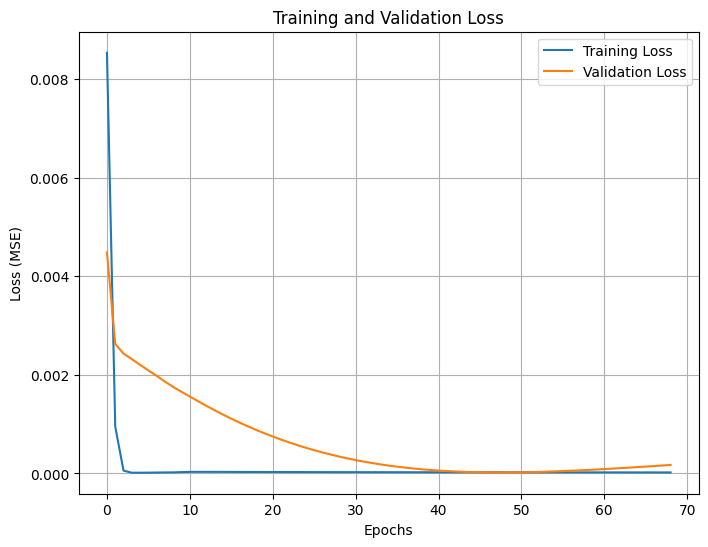

In [16]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save the model
model.save('plastic_strain_predictor_model_21.11.h5')

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

In [17]:
df_test= val_df[np.isclose(val_df['E'], 0)]

In [18]:
df_test

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,stress_rm,plastic_strain
262500,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,3.287824e-13,0.508937,0.000240,0.000000
262501,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,3.336225e-13,0.510879,0.000240,0.000000
262502,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,3.368475e-13,0.512174,0.000240,0.000000
262503,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,3.398335e-13,0.513372,0.000240,0.000000
262504,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,3.436733e-13,0.514914,0.000240,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263995,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,5.108166e-13,0.993472,0.000248,0.000016
263996,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,5.125339e-13,0.995426,0.000248,0.000016
263997,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,5.117231e-13,0.997057,0.000248,0.000016
263998,0.0,0.33375,0.671515,0.023136,0.752609,0.207,0.628597,0.164773,0.128508,0.470971,5.117658e-13,0.998704,0.000248,0.000016


In [19]:
X_test, y_test = df_test[['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi']].values, df_test['plastic_strain'].values

In [20]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [21]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [33]:
predictions = np.abs(model.predict(test_dataset))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [34]:
df_test.iloc[:,-1].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.61066687e-05, 1.61943190e-05, 1.62632377e-05])

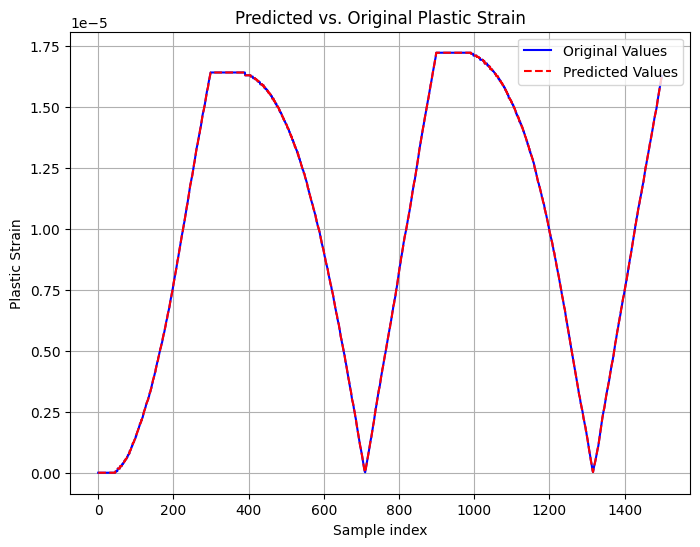

In [35]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(df_test.iloc[:,-1].values, df_test.iloc[:,-1].values, filename='predicted_vs_actual.png')

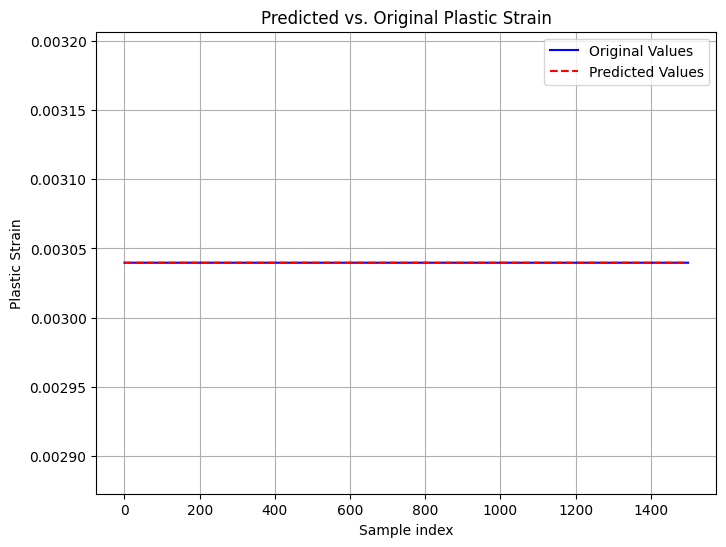

In [36]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(predictions, predictions, filename='predicted_vs_actual.png')

In [25]:
strain_values_test = df_test['strain']

In [26]:
y_pred_normalized_nn = np.squeeze(predictions)

In [27]:
stress_values_predicted =df_test['strain']*(strain_values_test - y_pred_normalized_nn)

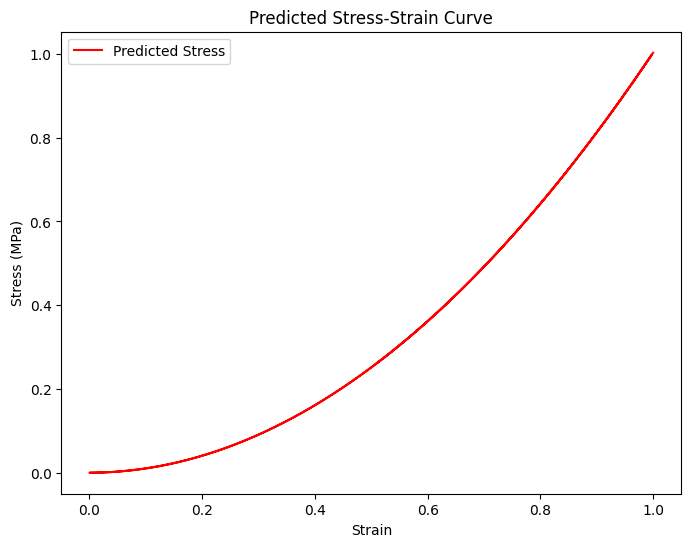

In [28]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
#plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

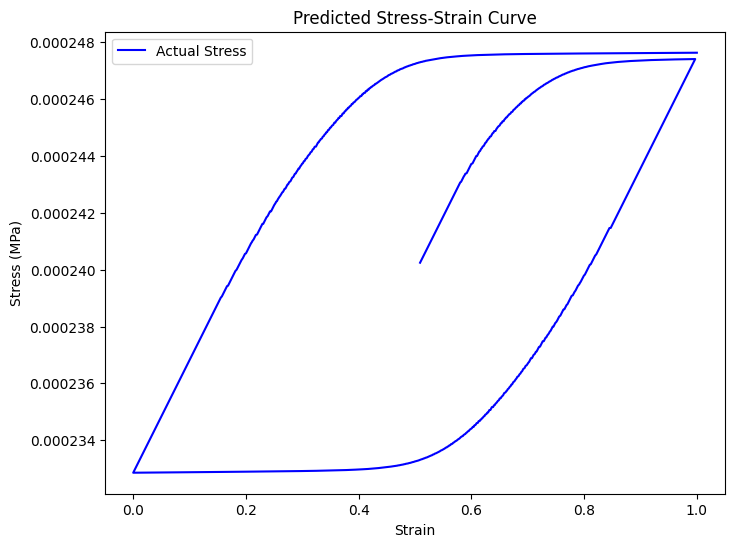

In [29]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

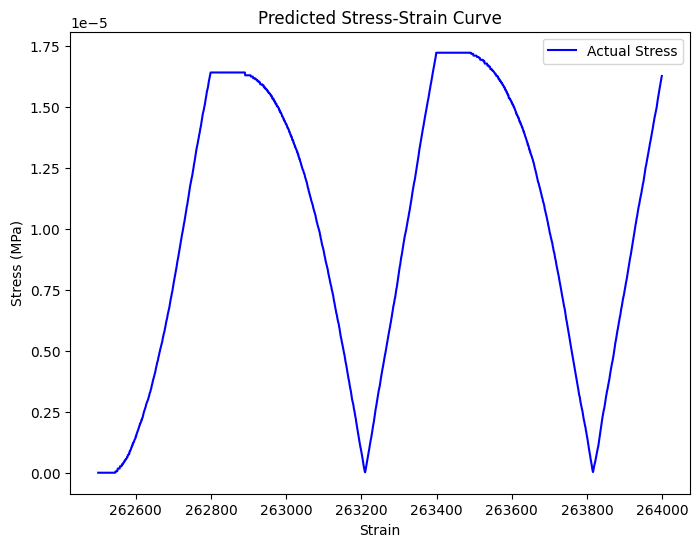

In [30]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot( df_test['plastic_strain'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

In [31]:
np.unique(val_df['b'])

array([0.00820724, 0.01269022, 0.02299867, 0.03705439, 0.04097324,
       0.04634339, 0.05544614, 0.07179778, 0.09216543, 0.0968009 ,
       0.09952592, 0.10419384, 0.12850774, 0.1412248 , 0.14617938,
       0.14795901, 0.16025848, 0.16039437, 0.16823131, 0.17314204,
       0.18572992, 0.19757868, 0.20277403, 0.21060185, 0.22444192,
       0.23541657, 0.24617294, 0.26746248, 0.27973215, 0.30393038,
       0.32616068, 0.34073506, 0.37578161, 0.37919318, 0.39342821,
       0.39586417, 0.40835106, 0.41035122, 0.42538243, 0.42971505,
       0.43661773, 0.44262174, 0.4458621 , 0.44860226, 0.46912222,
       0.49261692, 0.50370587, 0.50924129, 0.52086133, 0.52444381,
       0.52657108, 0.53390919, 0.54004161, 0.55510721, 0.5735316 ,
       0.58656084, 0.59126226, 0.59320246, 0.60281703, 0.61476176,
       0.62456125, 0.62967298, 0.63568814, 0.64086483, 0.65391609,
       0.65746896, 0.66581353, 0.67149497, 0.68540105, 0.70036363,
       0.70555753, 0.71065955, 0.71256867, 0.72957427, 0.73337